# Yolov4 Pytorch 1.7 for Edge Devices with Amazon SageMaker


Amazon SageMaker is a fully managed machine learning service. With SageMaker, data scientists and developers can quickly and easily build and train machine learning models, and then directly deploy them into a production-ready hosted environment. It provides an integrated Jupyter authoring notebook instance for easy access to your data sources for exploration and analysis, so you don't have to manage servers. It also provides common machine learning algorithms that are optimized to run efficiently against extremely large data in a distributed environment. With native support for bring-your-own-algorithms and frameworks, SageMaker offers flexible distributed training options that adjust to your specific workflows.

SageMaker also offers capabilities to prepare models for deployment at the edge. [SageMaker Neo](https://docs.aws.amazon.com/sagemaker/latest/dg/neo.html) is a capability of Amazon SageMaker that enables machine learning models to train once and run anywhere in the cloud and at the edge and [Amazon SageMaker Edge Manager](https://docs.aws.amazon.com/sagemaker/latest/dg/edge.html) provides model management for edge devices so you can optimize, secure, monitor, and maintain machine learning models on fleets of edge devices such as smart cameras, robots, personal computers, and mobile devices.


In this notebook we'll train a [**Yolov4**](https://github.com/WongKinYiu/PyTorch_YOLOv4) model on Pytorch using Amazon SageMaker to draw bounding boxes around images and then, compile and package it so that it can be deployed on an edge device(in this case, a [Jetson Xavier](https://developer.nvidia.com/jetpack-sdk-441-archive)).



## 1) Pre-requisites

Let us start with setting up the pre-requisites for this notebook. First, we will sagemaker and other related libs and then set up the role and buckets and some variables. Note that, we are also specifying the size of the image and also the model size taken as Yolov4s where s stand for small. Check out the [github doc of yolov4](https://github.com/WongKinYiu/PyTorch_YOLOv4) to understand how model sizes differ.

In [1]:
import sagemaker
import numpy as np
import glob
import os
from sagemaker.pytorch.estimator import PyTorch

role = sagemaker.get_execution_role()
sagemaker_session=sagemaker.Session()
bucket_name = sagemaker_session.default_bucket()
img_size= 512
model_type='tiny' # tiny or ''
model_name='yolov4'if model_type=='' else f"yolov4-{model_type}"

## 2) Download a public implementation of Yolov4 for Pytorch (Author: Wong Kin Yiu)

Now, we will download the PyTorch implementation of Yolov4 from this [repository](https://github.com/WongKinYiu/PyTorch_YOLOv4) which is authored by Wong Kin Yiu. We will place it in a local directory `yolov4`

In [2]:
if not os.path.isdir('yolov4'):
    !git clone https://github.com/WongKinYiu/PyTorch_YOLOv4 yolov4
    !cd yolov4 && git checkout 3c42cbd1b0fa28ad19436d01e0e240404463ff80 && git apply ../mish.patch
    !echo 'tensorboard' > yolov4/requirements.txt

## 2.1) Train the model by preparing a Python script that will be the entrypoint of the training process

Now, we will create a training script to train the Yolov4 model. The training script will wrap the original training scripts and expose the parameters to SageMaker Estimator. The script accepts different arguments which will control the training process.

In [3]:
%%writefile yolov4/sagemaker_train.py
import sys
import subprocess
## We need to remove smdebug to avoid the Hook bug https://github.com/awslabs/sagemaker-debugger/issues/401
subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", "smdebug"])
import os
import yaml
import argparse
import torch
import shutil
import urllib
from models.models import Darknet

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--num-classes', type=int, default=80, help='Number of classes')
    parser.add_argument('--img-size', type=int, default=512, help='Size of the image')
    parser.add_argument('--epochs', type=int, default=1, help='Number of epochs')
    parser.add_argument('--batch-size', type=int, default=16, help='Batch size')
    parser.add_argument('--adam', action='store_true', help='use torch.optim.Adam() optimizer')
    parser.add_argument('--pretrained', action='store_true', help='use pretrained model')
    
    parser.add_argument('--model-dir', type=str, default=os.environ["SM_MODEL_DIR"], help='Trained model dir')
    parser.add_argument('--train', type=str, default=os.environ["SM_CHANNEL_TRAIN"], help='Train path')
    parser.add_argument('--train-suffix', type=str, default='', help='Train path suffix')
    parser.add_argument('--validation', type=str, default=os.environ["SM_CHANNEL_VALIDATION"], help='Validation path')
    parser.add_argument('--validation-suffix', type=str, default='', help='Validation path suffix')
    
    parser.add_argument('--model-type', type=str, choices=['', 'tiny'], default="", help='Model type')
    
    # hyperparameters
    with open('data/hyp.scratch.yaml', 'r') as f:
        hyperparams = yaml.load(f, Loader=yaml.FullLoader)    
    for k,v in hyperparams.items():
        parser.add_argument(f"--{k.replace('_', '-')}", type=float, default=v)
    
    args,unknown = parser.parse_known_args()
    
    base_path=os.path.dirname(__file__)
    project_dir = os.environ["SM_OUTPUT_DATA_DIR"]

    # prepare the hyperparameters metadat
    with open(os.path.join(base_path,'data', 'hyp.custom.yaml'), 'w' ) as y:
        y.write(yaml.dump({h:vars(args)[h] for h in hyperparams.keys()}))

    # prepare the training data metadata
    with open(os.path.join(base_path,'data', 'custom.yaml'), 'w') as y:
        y.write(yaml.dump({            
            'names': [f'class_{i}' for i in range(args.num_classes)],
            'train': os.path.join(args.train, args.train_suffix),
            'val': os.path.join(args.validation, args.validation_suffix),
            'nc': args.num_classes
        }))
    model_name = "yolov4" if len(args.model_type) == 0 else f"yolov4-{args.model_type}"
    # run the training script
    weights_file=''
    if args.pretrained:
        weights_file = f'weights/{model_name}.weights'
        urllib.request.urlretrieve(
            f'https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/{model_name}.weights',
            weights_file
        )

    train_cmd = [
        sys.executable, os.path.join(base_path,'train.py'),
        "--data", "custom.yaml",
        "--hyp", "hyp.custom.yaml",
        "--cfg", f"cfg/{model_name}.cfg",
        "--img", str(args.img_size),
        "--batch", str(args.batch_size),
        "--epochs", str(args.epochs),
        "--logdir", project_dir,
        "--weights", weights_file
    ]
    if args.adam: train_cmd.append("--adam")
    subprocess.check_call(train_cmd)
        
    # tracing and saving the model
    inp = torch.rand(1, 3, args.img_size, args.img_size).cpu()
    ckpt = torch.load(os.path.join(project_dir, 'exp0', 'weights', 'best.pt'), map_location='cpu')
    model = Darknet(f"cfg/{model_name}.cfg").cpu()
    # do not invoke .eval(). we don't need the detection layer
    model.load_state_dict(ckpt['model'], strict=False)
    p = model(inp)
    model_trace = torch.jit.trace(model, inp)
    model_trace.save(os.path.join(args.model_dir, 'model.pth'))

Overwriting yolov4/sagemaker_train.py


### 2.1.2) Preparing the dataset

Here we'll download a sample dataset [coco128](https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip). We can also replace this step with any other dataset. 

Just take a look on the labels format and create your dataset scructure following the same standard (COCO).

In [6]:
import os
#if not os.path.exists('coco128'):
#    !wget -q https://github.com/ultralytics/yolov5/releases/download/v1.0/coco128.zip
#    !unzip -q coco128.zip && rm -f coco128.zip
print('BBoxes annotation')
print('class x_center y_center width height')
!head panelscoco512/labels/2_3-1_thermal_cropped0.txt

BBoxes annotation
class x_center y_center width height
0 0.983154 0.667764 0.019668 0.025449
1 0.145215 0.276865 0.290430 0.192754


### 2.1.3) Upload the dataset to S3

Once the dataset has been downloaded locally, we'll upload the dataset to an S3 bucket created earlier. We are setting up the training and validation dataset s3 locations here.

In [7]:
prefix='data/panelscoco512'
!rm -f panelscoco512/labels/train2022.cache
train_path = sagemaker_session.upload_data('panelscoco512', key_prefix=f'{prefix}/train')
val_path = sagemaker_session.upload_data('panelscoco512', key_prefix=f'{prefix}/val')
print(train_path, val_path)

s3://sagemaker-eu-west-1-763989535729/data/panelscoco512/train s3://sagemaker-eu-west-1-763989535729/data/panelscoco512/val


### 2.1.4) Prepare the SageMaker Estimator to train the model

Now it's time to create an Estimater and train the model with the training script created in earlier step. We are using Pytorch estimator and supplying other arguments in the estimator. Note that we are supplying the `source_dir` so that sagemaker can pick up the training script and other related files from there. Once the estimator is ready, we start the training using the `.fit()` method.

In [8]:
estimator = PyTorch(
    'sagemaker_train.py',
    source_dir='yolov4',
    framework_version='1.7',
    role=role,
    sagemaker_session=sagemaker_session,
    instance_type='ml.p2.xlarge',    
    instance_count=1,
    py_version='py3', 
    hyperparameters={
        'epochs': 20, # at least 2 epochs
        'batch-size': 8,
        'lr0': 0.0001,
        'pretrained': True, # transfer learning
        'num-classes': 2,
        'img-size': img_size,
        'model-type': model_type,
        'train-suffix': 'images',
        'validation-suffix': 'images'
    }
)

In [9]:
estimator.fit({'train': train_path, 'validation': val_path})

2022-03-18 17:08:22 Starting - Starting the training job...
2022-03-18 17:08:47 Starting - Preparing the instances for trainingProfilerReport-1647623300: InProgress
.........
2022-03-18 17:10:08 Downloading - Downloading input data......
2022-03-18 17:11:19 Training - Downloading the training image........................
2022-03-18 17:15:16 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-03-18 17:15:20,650 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-03-18 17:15:20,682 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-03-18 17:15:20,702 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-03-18 17:15:21,322 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.6 -m pip install 

In [10]:
s3_uri=f'{estimator.output_path}{estimator.latest_training_job.name}/output/model.tar.gz'
print('trained model: ' + s3_uri )

trained model: s3://sagemaker-eu-west-1-763989535729/pytorch-training-2022-03-18-17-08-20-984/output/model.tar.gz


## 4) Compile your trained model for the edge device

Once the model has been traied, we need to compile the model using SageMaker Neo. This step is needed to compile the model for the specific hardware on which this model will be deployed. 

In this notebook, we will compile a model for [Jetson Xavier Jetpack 4.4.1](https://developer.nvidia.com/jetpack-sdk-441-archive). 

In case, you want to compile for a different hardware platform, just change the parameters bellow to adjust the target to your own edge device. Also, note, that if you dont have GPU available on the hardware device, then you can comment the `Accelerator` key:value in the `OutputConfig`.

The below cell also calls the `describe_compilation_job` API in a loop to wait for the compilation job to complete. In actual applications, it is advisable to setup a cloudwatch event which can notify OR execute the next steps once the compilation job is complete.

In [13]:
import time
import boto3
sm_client = boto3.client('sagemaker')
compilation_job_name = f'{model_name}-pytorch-{int(time.time()*1000)}'
sm_client.create_compilation_job(
    CompilationJobName=compilation_job_name,
    RoleArn=role,
    InputConfig={
        'S3Uri': s3_uri,
        'DataInputConfig': f'{{"input": [1,3,{img_size},{img_size}]}}',
        'Framework': 'PYTORCH'
    },
    OutputConfig={
        'S3OutputLocation': f's3://{sagemaker_session.default_bucket()}/{model_name}-pytorch/optimized/',
        'TargetPlatform': { 
            'Os': 'LINUX', 
            'Arch': 'X86_64'#, # change this to X86_64 if you need
            #'Arch': 'ARM64', # change this to X86_64 if you need
            #'Accelerator': 'NVIDIA'  # comment this if you don't have an Nvidia GPU
        }#,
        # Comment or change the following line depending on your edge device
        # Jetson Xavier: sm_72; Jetson Nano: sm_53
        #'CompilerOptions': '{"trt-ver": "7.1.3", "cuda-ver": "10.2", "gpu-code": "sm_53"}' # Jetpack 4.4.1
    },
    StoppingCondition={ 'MaxRuntimeInSeconds': 900 }
)
while True:
    resp = sm_client.describe_compilation_job(CompilationJobName=compilation_job_name)    
    if resp['CompilationJobStatus'] in ['STARTING', 'INPROGRESS']:
        print('Running...')
    else:
        print(resp['CompilationJobStatus'], compilation_job_name)
        break
    time.sleep(5)


Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
Running...
COMPLETED yolov4-tiny-pytorch-1647624912575


## 5) Download the compiled model

In [14]:
output_model_path = f's3://{sagemaker_session.default_bucket()}/{model_name}-pytorch/optimized/model-LINUX_X86_64.tar.gz'
!aws s3 cp $output_model_path /tmp/model.tar.gz
!rm -rf model_object_detection && mkdir model_object_detection
!tar -xzvf /tmp/model.tar.gz -C model_object_detection

download: s3://sagemaker-eu-west-1-763989535729/yolov4-tiny-pytorch/optimized/model-LINUX_X86_64.tar.gz to ../../../tmp/model.tar.gz
compiled_model.json
compiled.so
dlr.h
libdlr.so
compiled.meta
compiled.params
manifest


## 6) Run the model locally

In [47]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Classes
labels= ['1', '0']  # class names

### 6.1) Load the model using the runtime DLR

In [ ]:
!pip install dlr==1.8.0

In [18]:
import dlr
# load the model (CPU x86_64)


2022-03-18 17:41:48,999 INFO Found libdlr.so in model artifact. Using dlr from model_object_detection/libdlr.so



 CALL HOME FEATURE ENABLED
                            

 You acknowledge and agree that DLR collects the following metrics to help improve its performance.                             
 By default, Amazon will collect and store the following information from your device:                             

 record_type: <enum, internal record status, such as model_loaded, model_>,                             
 arch: <string, platform architecture, eg 64bit>,                             
 osname: <string, platform os name, eg. Linux>,                             
 uuid: <string, one-way non-identifable hashed mac address, eg. 8fb35b79f7c7aa2f86afbcb231b1ba6e>,                             
 dist: <string, distribution of os, eg. Ubuntu 16.04 xenial>,                             
 machine: <string, retuns the machine type, eg. x86_64 or i386>,                             
 model: <string, one-way non-identifable hashed model name, eg. 36f613e00f707dbe53a64b1d9625ae7d>                         

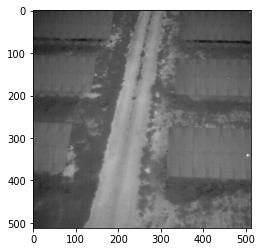

In [54]:
import utils

# Read the image using OpenCV
img = cv2.imread('./panelscoco512/images/2_3-1_thermal_cropped0.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)

In [55]:
import utils

modelDLR = dlr.DLRModel('model_object_detection', 'cpu')

def predict(model, x):
    return model.run(x)[0]

confidence_treshold=0.1
# Convert the image to the expected network input
x = utils.preprocess_img(img, img_size=512)
# Run the model and get the predictions
preds = predict(modelDLR, x)
# Convert the predictions into Detections(bounding boxes, scores and class ids)
detections = utils.detect(preds, 0.25, 0.5, True)
# Iterate over the detections and do what you need to do
for top_left_corner,bottom_right_corner, conf, class_id in detections:
    if confidence_treshold < 0.1: continue
    print( f"bbox: {top_left_corner},{bottom_right_corner}, score: {conf}, class_id: {class_id}")

2022-03-21 17:17:15,584 INFO Found libdlr.so in model artifact. Using dlr from model_object_detection/libdlr.so


ValueError: not enough values to unpack (expected 5, got 4)

## 7) Create a SageMaker Edge Manager packaging job

Once the model has been compiled, it is time to create an edge manager packaging job. Packaging job take SageMaker Neo–compiled models and make any changes necessary to deploy the model with the inference engine, Edge Manager agent.

We need to provide the name used for the Neo compilation job, a name for the packaging job, a role ARN, a name for the model, a model version, and the Amazon S3 bucket URI for the output of the packaging job. Note that Edge Manager packaging job names are case-sensitive.


The below cell also calls the `describe_edge_packaging_job` API in a loop to wait for the packaging job to complete. In actual applications, it is advisable to setup a cloudwatch event which can notify OR execute the next steps once the compilation job is complete.

In [28]:
import time
model_version = '1.0'
edge_packaging_job_name=f'{model_name}-pytorch-{int(time.time()*1000)}'
resp = sm_client.create_edge_packaging_job(
    EdgePackagingJobName=edge_packaging_job_name,
    CompilationJobName=compilation_job_name,
    ModelName=model_name,
    ModelVersion=model_version,
    RoleArn=role,
    OutputConfig={
        'S3OutputLocation': f's3://{bucket_name}/{model_name}'
    }
)
while True:
    resp = sm_client.describe_edge_packaging_job(EdgePackagingJobName=edge_packaging_job_name)    
    if resp['EdgePackagingJobStatus'] in ['STARTING', 'INPROGRESS']:
        print('Running...')
    else:
        print(resp['EdgePackagingJobStatus'], compilation_job_name)
        print('package s3 location: ' + 's3://'+bucket_name+'/'+model_name)
        break
    time.sleep(5)

Running...
Running...
Running...
Running...
Running...
COMPLETED yolov4-tiny-pytorch-1646239286493
package s3 location: s3://sagemaker-eu-west-1-763989535729/yolov4-tiny


# 8) Pre processing + Post processing code
After compiling your model, it's time to prepare the application that will use it. In the image bellow you can see the operators that are used by the last layer **YOLOLayer**. When in evaluation mode, this layer applies some operations to merge the two outputs of the network and prepare the predictions for the **Non Maximum Suppression**. In training model, you just have the two raw outputs. 

Given we're using a pruned version (training mode) of the network, you need to apply some post processing code to your predictions.

<table style="border: 1px solid black; border-collapse: collapse;" border=3 cellpadding=0 cellspacing=0>
    <tr style="border: 1px solid black;">
        <td style="text-align: center; border-right: 1px solid;" align="center"><b>WITH DETECTION (evaluation mode)</b></td>
        <td style="text-align: center;" align="center"><b>NO DETECTION (training mode)</b></td>
    </tr>    
    <tr style="border: 1px solid black; border-right: 1px solid;">
        <td width="75%" style="border-right: 1px solid;">
            <img src="yolov4/imgs/yolov4_detection.png"/>
        </td>
        <td>
            <img src="yolov4/imgs/yolov4_no_detection.png"/>
        </td>
    </tr>
</table>

All the operations required by this process can be found in the script **[Utils](utils.py)**.
#### WARNING: run the next cell and copy the output to your **utils.py** before running the application. It is necessary to adjust the anchors and scores for the correct yolov4 version


Here it is an example of how to use the code:
```Python
import utils

### your code here
### def predict(model, x):...

confidence_treshold=0.1
# Read the image using OpenCV
img = cv2.imread('dog.jpg')
# Convert the image to the expected network input
x = utils.preprocess_img(img, img_size=416)
# Run the model and get the predictions
preds = predict(model, x)
# Convert the predictions into Detections(bounding boxes, scores and class ids)
detections = utils.detect(preds, 0.25, 0.5, True)
# Iterate over the detections and do what you need to do
for top_left_corner,bottom_right_corner, conf, class_id in detections:
    if confidence_treshold < 0.1: continue
    print( f"bbox: {top_left_corner},{bottom_right_corner}, score: {conf}, class_id: {class_id}")
```

In [29]:
## This code parses the .cfg file of the version you're using and
## Prints the correct anchors/stride. Copy the output to the 'utils.py' file used by your application
import numpy as np

cfg_filename=f'yolov4/cfg/{model_name}.cfg'
yolo_layer=False
yolo_layers = []

for i in open(cfg_filename, 'r').readlines(): # read the .cfg file
    i = i.strip()
    if len(i) == 0 or i.startswith('#'): continue # ignore empty lines and comments
    elif i.startswith('[') and i.endswith(']'): # header
        if i.lower().replace(' ', '') == '[yolo]':
            yolo_layer = True # yolo layer
            yolo_layers.append({})
    elif yolo_layer: # properties of the layer
        k,v = [a.strip() for a in i.split('=')] # split line into key, value
        if k == 'anchors': # parse anchors
            anchors = np.array([int(j.strip()) for j in v.split(',')])
            yolo_layers[-1]['anchors'] = anchors.reshape((len(anchors)//2, 2))
        elif k == 'mask': # parse mask
            yolo_layers[-1]['mask'] = np.array([int(j.strip()) for j in v.split(',')])

stride = [8, 16, 32, 64, 128]  # P3, P4, P5, P6, P7 strides
if model_type == 'tiny':  # P5, P4, P3 strides
    stride = [32, 16, 8]

print("##### Copy the following lines to your util.py")
print(f"anchors = {[l['anchors'][l['mask']].tolist() for l in yolo_layers]}")
print(f"stride = {stride}")

##### Copy the following lines to your util.py
anchors = [[[81, 82], [135, 169], [344, 319]], [[23, 27], [37, 58], [81, 82]]]
stride = [32, 16, 8]


### Done !!

And we are done with all the steps needed to prepare the model for deploying to edge. The model package is avaialble in S3 and can be taken from there to deploy it to edge device. Now you need to move over to your edge device and download and setup edge manager agent(runtime), model and other related artifacts on the device. Please check out the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/edge.html) for detailed steps.